# Training a neural network model to generate a document deformation mesh in an image.

Author: Maciej Kubiś

Date: 2025-03-24

The notebook will allow training of various AI models created using **PyTorch**. Various architectures modeled on **U-Net** will be tested.

In [1]:
scale = 0.05

for i in range(220):
    scale *= 1.01

print("Scale after 210 iterations:", scale)

Scale after 210 iterations: 0.44634660574422114


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib.util
import sys

sys.path.append("../src") 

spec = importlib.util.spec_from_file_location("data_generator", "../src/data_generator.py")
data_generator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_generator)

spec = importlib.util.spec_from_file_location("neuralnet_handler", "../src/neuralnet_handler.py")
neuralnet_handler = importlib.util.module_from_spec(spec)
spec.loader.exec_module(neuralnet_handler)

## Configuration

It is possible to set device where will be handle neural network. Image generator require file with any text to produce random content of documents.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = data_generator.DocumentImageGenerator("../src/assets/text.txt")

nn_handler = neuralnet_handler.NeuralNetHandler(None, generator, device, 220, 0.01, 20)

Using device: cpu
Model is None. Please provide a valid model using set_model() method.


## U-Net with batch normalization

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetFlexible(nn.Module):
    def __init__(self, base_channels=64):
        super(UNetFlexible, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, base_channels)
        self.enc2 = self.conv_block(base_channels, base_channels * 2)
        self.enc3 = self.conv_block(base_channels * 2, base_channels * 4)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(base_channels * 4, base_channels * 8)

        # Decoder
        self.up3 = self.up_block(base_channels * 8, base_channels * 4)
        self.up2 = self.up_block(base_channels * 4 * 2, base_channels * 2)
        self.up1 = self.up_block(base_channels * 2 * 2, base_channels)

        # Final layer
        self.final_conv = nn.Conv2d(base_channels * 2, 2, kernel_size=1)  # 2 channels for (x, y) offsets

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        e3 = F.interpolate(e3, size=d3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e3], dim=1)

        d2 = self.up2(d3)
        e2 = F.interpolate(e2, size=d2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e2], dim=1)

        d1 = self.up1(d2)
        e1 = F.interpolate(e1, size=d1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e1], dim=1)

        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)

        return out


model = UNetFlexible(base_channels=64)  # You can adjust base_channels as needed
nn_handler.set_model(model, "unet_deform")

#### Function for plotting results:

In [8]:
from IPython.display import clear_output

def plot():
    # Clear the output before plotting
    clear_output(wait=True)

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(nn_handler.get_train_losses(), label='Training Loss')
    plt.plot(nn_handler.get_val_losses(), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.title('Training and Validation Loss U-Net')
    plt.legend()
    plt.show()

### Training and results

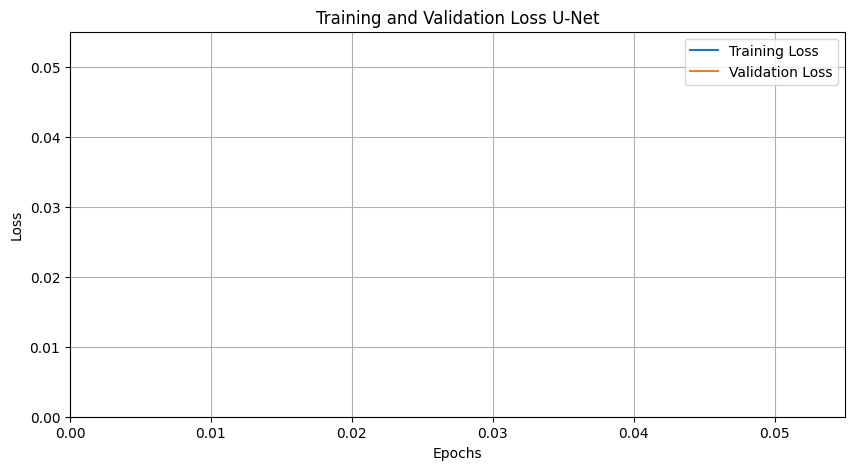

In [9]:
nn_handler.train()

plot()

#### Ensure model save

In [ ]:
nn_handler.save_model("../models/unet_deform.pth")

Model saved to ../models/unet_deform.pth
